# Physics-Informed Neural Networks

Physics-Informed Neural Networks (PINNs) are special types of Neural Networks that incorporate physical laws into their optimization process. This is usually realized by adding physical laws in the form of differential equations (in implicit form) to the cost function. This allows for the wanted solution not only to minimize the prediction error, but also to satisfy already known physical laws. PINNs allow for the integration of a priori scientific knowledge into data-driven ML models and result in better generalizations. This kind of cross between ML and science is often dubbed "SciML".

PINNs are mostly unsupervised and mesh-free (i.e. continuous in independent variables). Their convergence properties are not yet well understood, and their computational cost is usually much higher when compared to normal neural networks. They are also poor at scaling to larger domains and complex solutions.

This project is based on a crash course on PINNs with a guided demonstration by Ben Moseley that is available at the following address: https://youtu.be/G_hIppUWcsc?si=P1-v2H3RiHQ07PfD.
Some of the Markdown material (especially LateX-based) is borrowed from the author's Notebook.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # Windows safety

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Harmonic Oscillator (Underdamped version)

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif?raw=1" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above).

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

In [3]:
def exact_solution(delta, w0, t):
    "Analytical solution to the underdamped h.o."

    assert delta < w0 #for underdampened problem
    
    w = np.sqrt(w0**2 - delta**2)
    phi = np.arctan(-delta/w)
    A = 1 / (2*np.cos(phi))
    cos = torch.cos(w*t + phi)
    exp = torch.exp(-delta * t)
    u = 2 * A * exp * cos
    return u

### 1. Finding solution to Underdampened Harmonic Oscillator by Training a PINN to simulate the physical system

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful!

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

In [4]:
class FCN(nn.Module):
    "Defines a standard, fully connected Neural Network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh

        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        ])

        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()])
                        for _ in range(N_LAYERS-1)
        ])

        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Loss:  tensor(1.0219, grad_fn=<AddBackward0>)


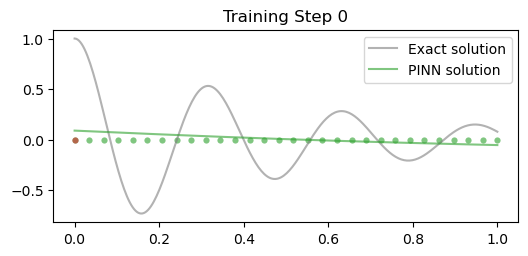

Loss:  tensor(0.0229, grad_fn=<AddBackward0>)


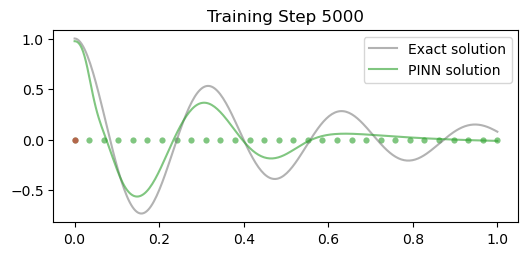

Loss:  tensor(0.0057, grad_fn=<AddBackward0>)


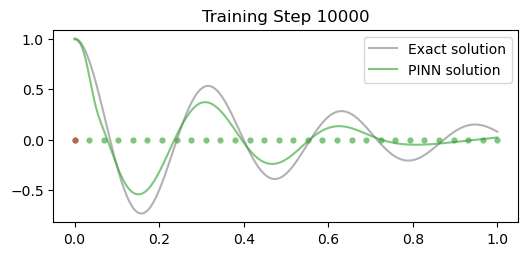

Loss:  tensor(0.0031, grad_fn=<AddBackward0>)


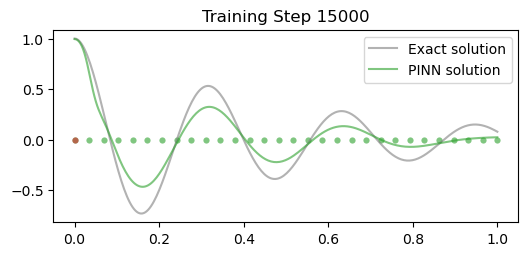

Loss:  tensor(0.0021, grad_fn=<AddBackward0>)


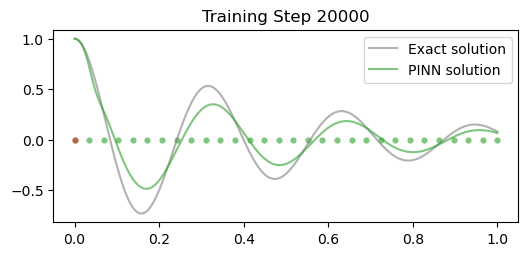

Loss:  tensor(0.0012, grad_fn=<AddBackward0>)


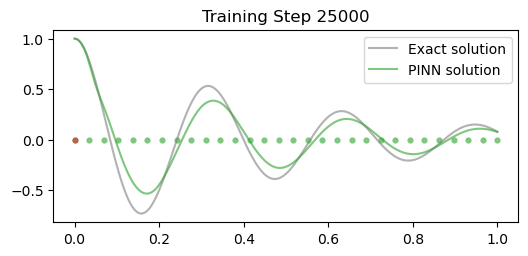

Loss:  tensor(0.0011, grad_fn=<AddBackward0>)


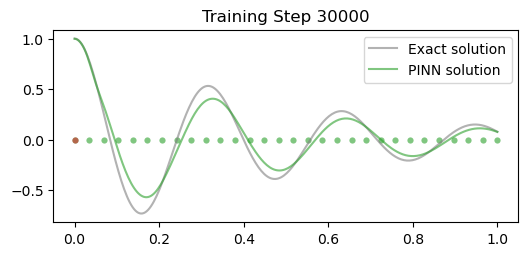

Loss:  tensor(0.0005, grad_fn=<AddBackward0>)


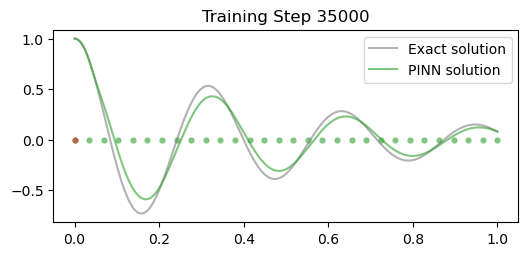

Loss:  tensor(0.0005, grad_fn=<AddBackward0>)


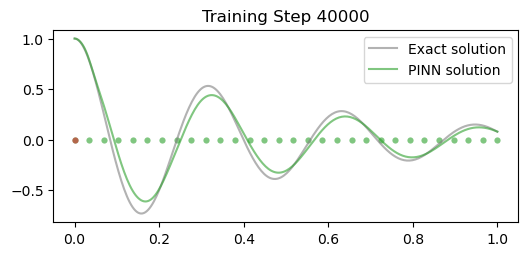

Loss:  tensor(0.0005, grad_fn=<AddBackward0>)


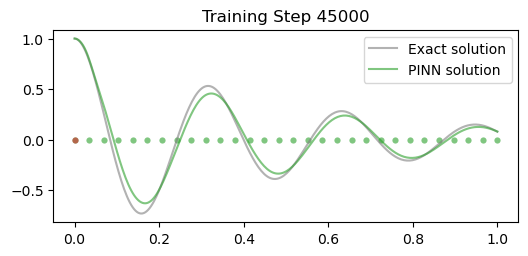

Loss:  tensor(0.0005, grad_fn=<AddBackward0>)


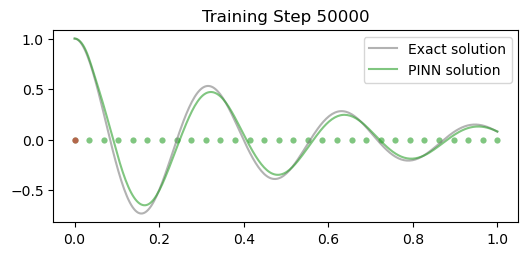

Loss:  tensor(0.0006, grad_fn=<AddBackward0>)


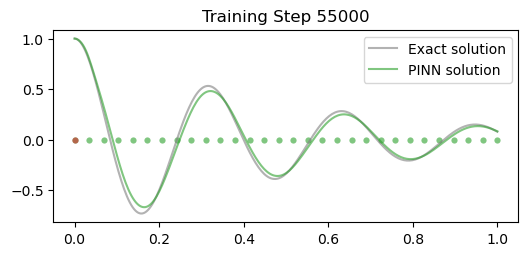

Loss:  tensor(0.0003, grad_fn=<AddBackward0>)


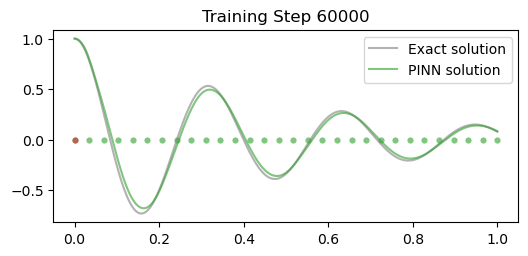

Loss:  tensor(0.0006, grad_fn=<AddBackward0>)


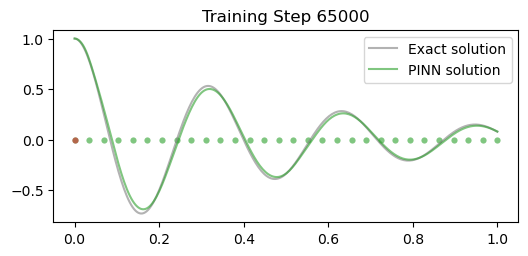

Loss:  tensor(0.0003, grad_fn=<AddBackward0>)


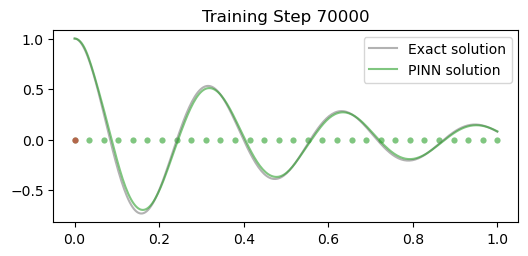

In [ ]:
torch.manual_seed(123)

def train_PINN_harmonic_oscillator(STEPS):
    "Trains PINN for the underdamped harmonic oscillator problem using known physical law."
    #Defining Neural 
    pinn = FCN(1, 1, 32, 3)

    #Defining boundary loss
    t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

    #Defining physics loss
    t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

    #Training loop for PINN
    d, w0 = 2, 20
    mu, k = 2*d, w0**2
    lambda1 = 1e-1
    lambda2 = 1e-4

    t_test = torch.linspace(0, 1, 300).view(-1,1)
    #Calculating exact solution
    u_exact = exact_solution(d, w0, t_test)
    optimizer = torch.optim.NAdam(pinn.parameters(), lr=1.2e-3)

    for i in range(STEPS):
        t_boundary = t_boundary.detach().requires_grad_(True)
        t_physics  = t_physics.detach().requires_grad_(True)

        optimizer.zero_grad()

        ### Compute terms in full loss function using hyperparameters ###

        #Compute boundary losses
        u = pinn(t_boundary) #value for u at t=0

        #Loss for initial condition: u(t=0) = 1
        loss1 = (torch.squeeze(u) -1 )**2

        dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] #IMPORTANT DETAIL FOR a tensor of ones that has to to do with the underlying Jacobian computation

        #Loss for initial condition: du/dt(t=0) = 0
        loss2 = (torch.squeeze(dudt) - 0)**2

        #Compute physics losses
        u = pinn(t_physics)
        dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
        d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
        loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2) #Assumed unit mass m=1 

        #Backpropagation
        loss = loss1 + lambda1 * loss2 + lambda2 * loss3
        loss.backward()
        optimizer.step()

        ### Plot results during training ###
        if  i % 5000 == 0:
            u = pinn(t_test).detach()
            plt.figure(figsize=(6, 2.5))
            plt.scatter(t_physics.detach()[:,0],
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
            plt.scatter(t_boundary.detach()[:,0],
                torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
            plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green", alpha=0.6)
            plt.title(f"Training Step {i}")
            print("Loss: ", loss)
            plt.legend()
            plt.show()

train_PINN_harmonic_oscillator(STEPS = 70001)

The above example is in reality just a solver of a differential equation (law of underdampened harmonic oscillation) using a Neural Network. <br> **Nowhere in these examples are we using actual empirical data/observations.**

### 2. Training a PINN to invert for underlying parameters (dampening factor $\mu$)

In this example, we WILL use observational data (namely the trajectory of the damped harmonic oscillator) to estimate a parameter inside the known differential equation governing the motion of the oscillator, namely the dampening factor, $\mu$.

The second task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement
- Outputs: estimate $\mu$, the coefficient of friction

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

The key idea here is to also treat $\mu$ as a **learnable parameter** when training the PINN - so that we both simulate the solution and invert for this parameter.

#### Loss function

The PINN is trained with a slightly different loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notes

There are two terms in the loss function here. The first is the **physics loss**, formed in the same way as above, which ensures the solution learned by the PINN is consistent with the know physics.

The second term is called the **data loss**, and makes sure that the solution learned by the PINN fits the (potentially noisy) observations of the solution that are available.

Note, we have removed the boundary loss terms, as we do not know these (i.e., we are only given the observed measurements of the system).

In this set up, the PINN parameters $\theta$ and $\mu$ are **jointly** learned during optimisation.

Again, autodifferentiation is our friend and will allow us to easily define this problem!

True value of mu: 4


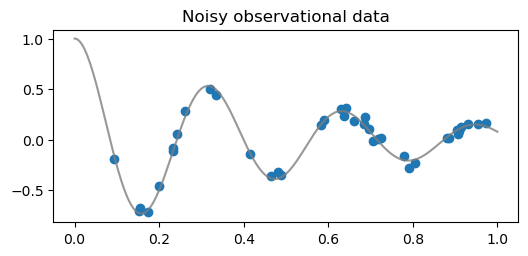

In [5]:
#Create some noisy observational data
torch.manual_seed(115)
d, w0 = 2, 20

print(fr'True value of mu: {2*d}')

t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04 * torch.randn_like(t_obs)

t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize = (6, 2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.8)
plt.show()

Loss  0 :  3386.78759765625


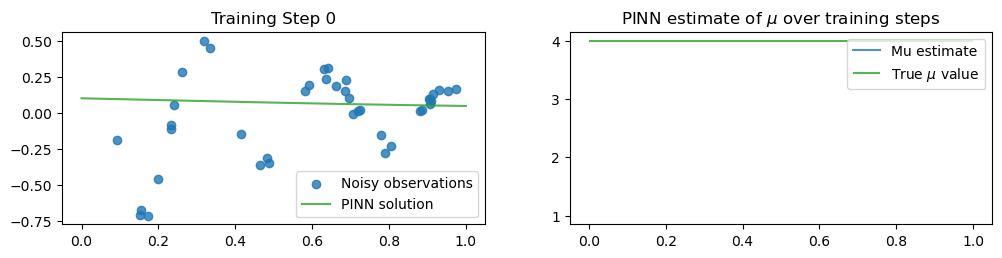

Loss  5000 :  823.6647338867188


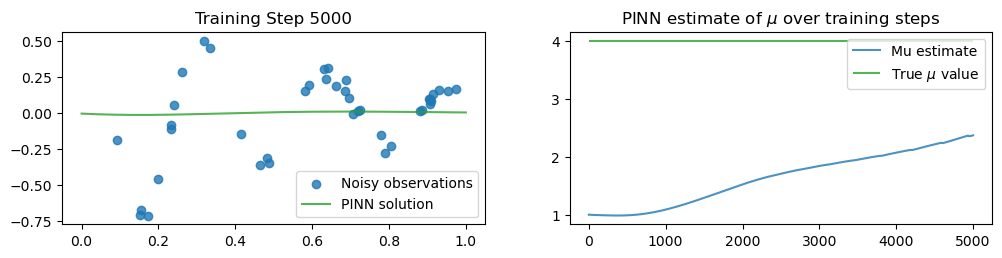

Loss  10000 :  260.9241943359375


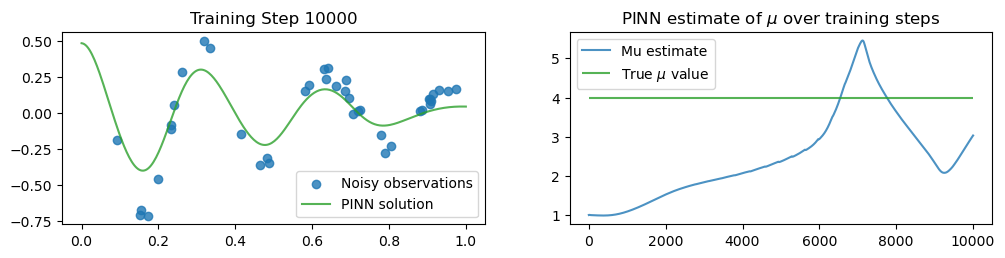

Loss  15000 :  46.761409759521484


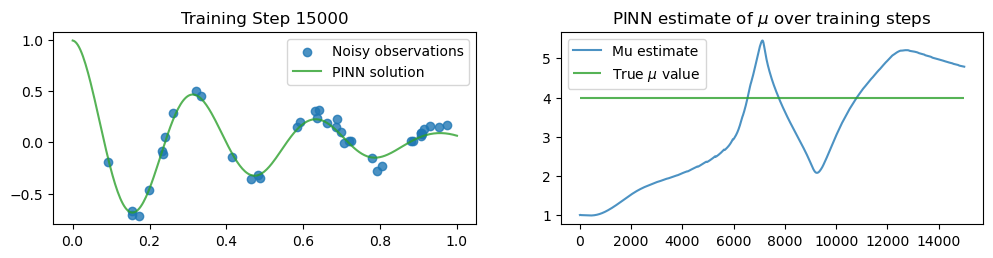

Loss  20000 :  20.181137084960938


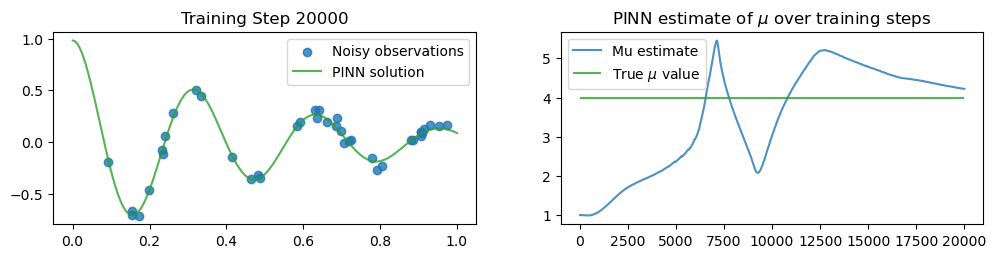

Loss  25000 :  21.34269905090332


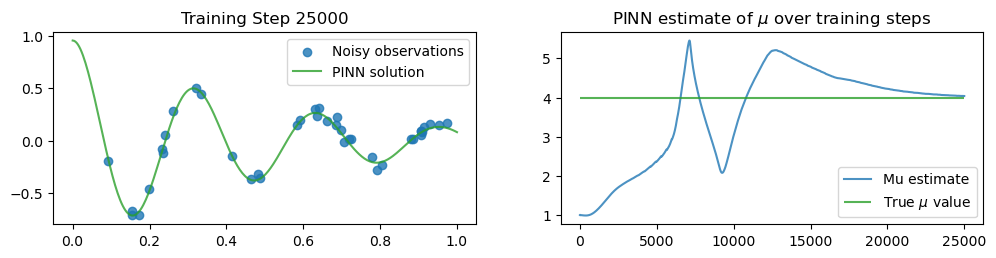

Loss  30000 :  15.972549438476562


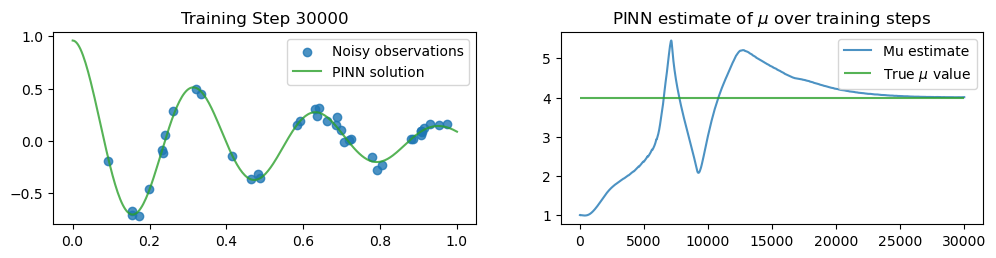

Loss  35000 :  16.84317398071289


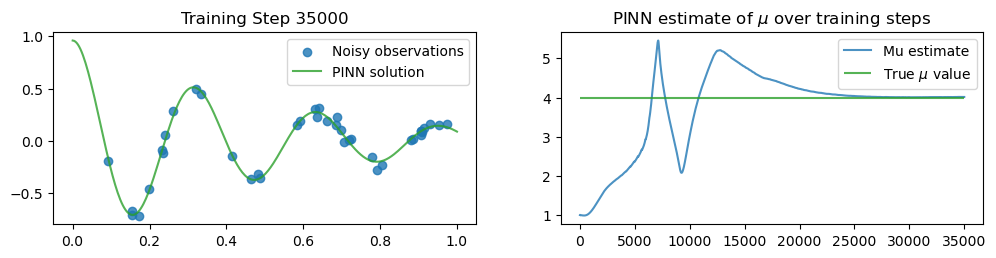

Loss  40000 :  15.256790161132812


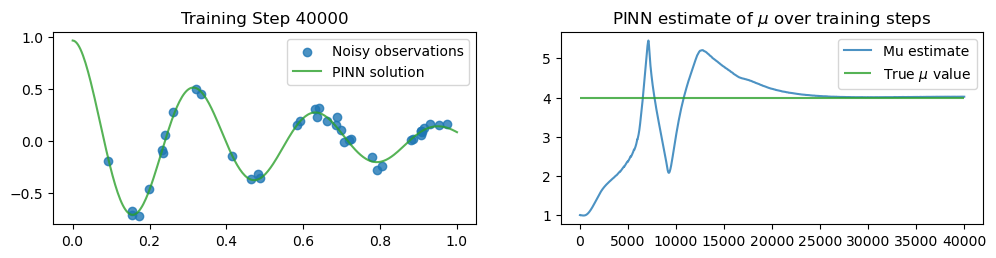

Loss  45000 :  14.995534896850586


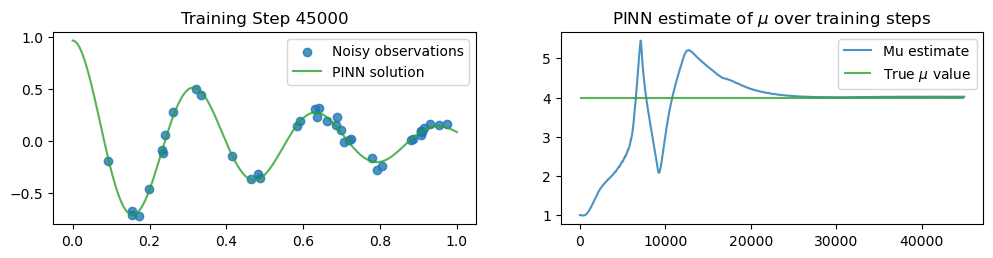

Loss  50000 :  31.198043823242188


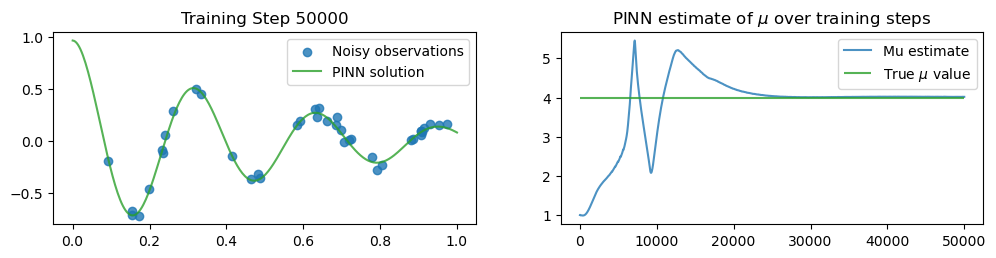

Loss  55000 :  14.719695091247559


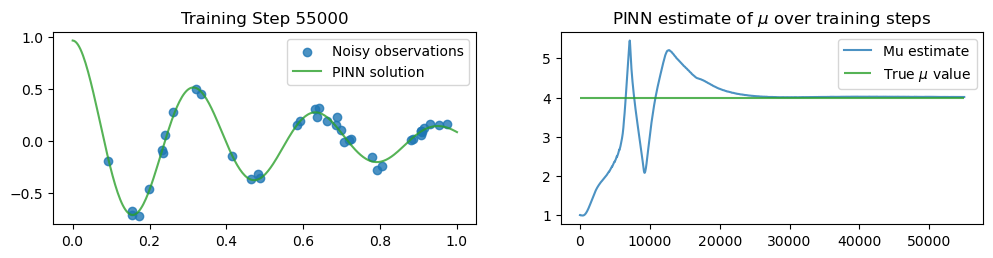

Loss  60000 :  14.58282470703125


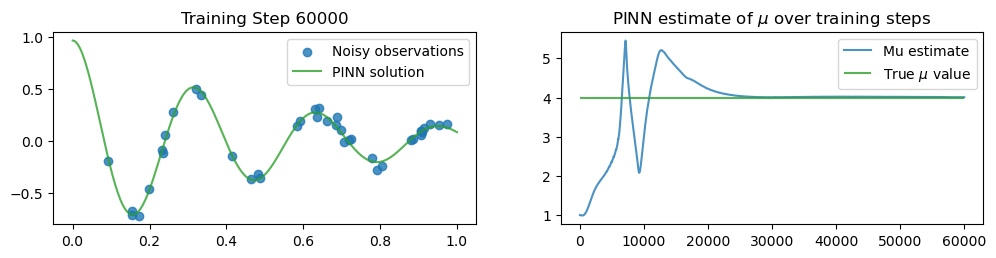

Loss  65000 :  14.287598609924316


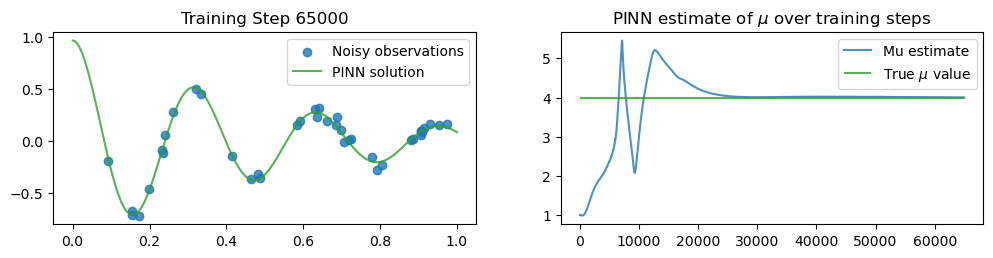

Loss  70000 :  29.252765655517578


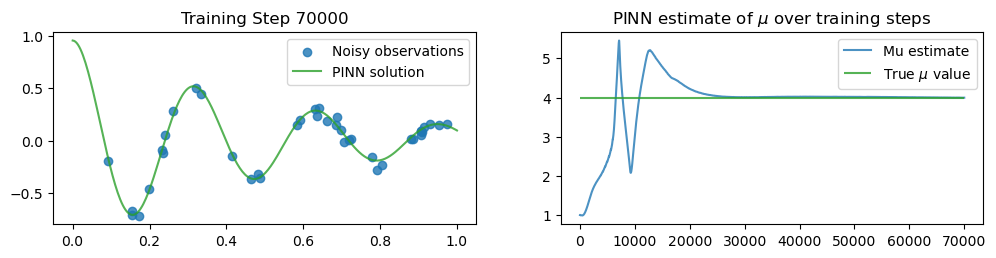

In [14]:
torch.manual_seed(115)

def train_PINN_inversion(NUM_STEPS=70001):
    pinn = FCN(1,1,32,3)

    t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

    #Training PINN
    d, w0 = 2, 20
    _, k = d*2, w0**2
    t_test = torch.linspace(0,1,300).view(-1,1)
    u_exact = exact_solution(d, 20, t_test)

    mu = torch.nn.Parameter(torch.tensor(1., requires_grad = True))
    optimizer = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)

    #Empty list for history of mus
    mus = []

    lambda1 = 1e4

    for i in range(NUM_STEPS):
        optimizer.zero_grad()

        #Computing Losses (Physics + Data Mean Squared Error)
        
        #1. Physics Loss
        u = pinn(t_physics)
        dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
        d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
        loss1 = torch.mean((d2udt2 + mu * dudt + k*u)**2) #Assumed unit mass m=1

        #2. Data Loss
        u = pinn(t_obs)
        loss2 = torch.mean((u-u_obs)**2)

        #Total loss
        loss = loss1 + lambda1 * loss2

        #Backpropagation and optimizer step
        loss.backward()
        optimizer.step()
        
        #Record mu value history
        mus.append(mu.item())

        if i % 5000 == 0:
            u = pinn(t_test).detach()
            plt.figure(figsize = (12, 2.5))

            plt.subplot(1,2,1)
            plt.title("Noisy observational data")
            plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", color="tab:blue", alpha=0.8)
            plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green", alpha=0.8)
            plt.title(f"Training Step {i}")
            plt.legend()


            print("Loss ", i,": " , loss.item())

            plt.subplot(1,2,2)
            plt.title(r"PINN estimate of $\mu$ over training steps")
            plt.plot(mus, label="Mu estimate", color="tab:blue", alpha=0.8)
            plt.hlines(2*d, 0, len(mus), label=r"True $\mu$ value", color="tab:green", alpha=0.8)
            plt.legend()
            plt.show()

train_PINN_inversion(NUM_STEPS=70001)

### PINNs for Equation Discovery

Try discovering Kepler's or Newton's Laws in the form of differential equations based on observed astronomical data and a library of operators.